In [ ]:
# default_exp examples00

In [ ]:
#hide
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#hide
!pip install nbdev
!pip install fastcore

In [ ]:
#hide
% cd /content/drive/My\ Drive/fa_convnav

In [ ]:
#hide
#not deps but we need them to use nbdev and run tests
from nbdev import * 
from nbdev.showdoc import *
from fastcore.test import *

# Examples00

> How to use fa_convnav to view a CNN pretrained model.

To run this notebook, `!pip install fa_convnav` and then `from fa_convnav.examples00 import *` then run. The notebook will install fastai2 for you if it is not already installed.

In [ ]:
#hide
try:
  import fastai2.basics
except:
  !pip install fastai2
else:
  print('fastai2 already installed')

Import fastai deep learning library including pretrained vision models.

In [ ]:
#export
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from torch import torch

Import the fa_convnav.navigator module

In [ ]:
#export
from fa_convnav.navigator import *

Create a fastai datablock using the Oxford PetsII dataset (included with fastai install).

In [ ]:
#export
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'),
                 item_tfms=Resize(460),
                 batch_tfms=[*aug_transforms(size=224, max_rotate=30, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

Create a dataloader which enables data loading onto the GPU in batches for training, applying some simple image transforms in the process.

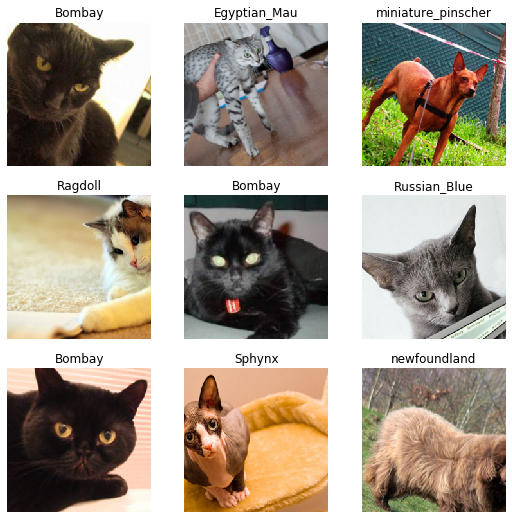

In [ ]:
#export
dls = pets.dataloaders(untar_data(URLs.PETS)/"images",  bs=128)
dls.show_batch(max_n=9)

Download the pretarined model we want to use

In [ ]:
#export
model = resnet18

Create a fastai Learner object from the dataloader, the chosen model, an optimiser and a metric to monitor training. 

In [ ]:
#export
learn = cnn_learner(
    dls, 
    model, 
    opt_func=partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8), 
    metrics=error_rate, 
    config=cnn_config(ps=0.33)).to_fp16()

We can now instantiate a ConvNav instance.

In [ ]:
#export
cn = ConvNav(learn, learn.summary())

Creating an instance automatically builds a datraframe representation of the model (a CNDF dataframe). This step can take a few moments, especially for larger models such as densenets or xresnets which have hundreds of modules. If you have more than one Learner in your project, instantiate a separate ConvNav instance for each one. 

Once our dataframe is built we can view, search and select from it. For example, print some summary information:

In [ ]:
#export
print(cn.model_info)

Resnet: Resnet18
Input shape: [128 x 3 x 224 x 224] (bs, ch, h, w)
Output features: [128 x 37] (bs, classes)
Currently frozen to parameter group 3 out of 3


Examine summary information about the body and head of the model.

In [ ]:
#export
cn.divs

Resnet: Resnet18
Input shape: [128 x 3 x 224 x 224] (bs, ch, h, w)
Divisions:  body (0), head (1)



,Module_name,Model,Division,Container_child (num),Container_block (num),Layers,Torch_class,Output_dimensions,Parameters,Trainable,Currently
Index,,,,,,,,,,,
1,0,resnet18,Sequential,8,8,53,torch.nn.modules.container.Sequential,[128 x 512 x 7 x 7],11176512,,Frozen
67,1,resnet18,Sequential,9,0,10,torch.nn.modules.container.Sequential,[128 x 37],546304,,


View the whole CNDF dataframe. Only the first ten modules are displayed here for brevity, but set `top = True` and all 79 rows (named_modules in the resnet18 model) will be shown. Run the notebook and try it!

In [ ]:
#export
cn.view(top=True)

Resnet: Resnet18
Input shape: [128 x 3 x 224 x 224] (bs, ch, h, w)
Output features: [128 x 37] (bs, classes)
Currently frozen to parameter group 3 out of 3



,Module_name,Model,Division,Container_child,Container_block,Layer_description,Torch_class,Output_dimensions,Parameters,Trainable,Currently
Index,,,,,,,,,,,
0,,Sequential,,,,,torch.nn.modules.container.Sequential,,,,
1,0,,Sequential,,,,torch.nn.modules.container.Sequential,,,,
2,0.0,,,Conv2d,,"Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)",torch.nn.modules.conv.Conv2d,[128 x 64 x 112 x 11],"9,408",False,Frozen
3,0.1,,,BatchNorm2d,,"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",torch.nn.modules.batchnorm.BatchNorm2d,[128 x 64 x 112 x 11],128,True,
4,0.2,,,ReLU,,ReLU(inplace=True),torch.nn.modules.activation.ReLU,[128 x 64 x 112 x 11],0,False,
5,0.3,,,MaxPool2d,,"MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)",torch.nn.modules.pooling.MaxPool2d,[128 x 64 x 56 x 56],0,False,
6,0.4,,,Sequential,,,torch.nn.modules.container.Sequential,,,,
7,0.4.0,,,,BasicBlock,,torchvision.models.resnet.BasicBlock,,,,
8,0.4.0.conv1,,,,,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,[128 x 64 x 56 x 56],"36,864",False,Frozen


...69 more layers


We can examine the layers of the head only. 

In [ ]:
#export
cn.head

Resnet: Resnet18
Input shape: [128 x 512 x 7 x 7] (bs, filt, h, w)
Output features: [128 x 37] (bs, classes)



,Module_name,Model,Division,Container_child,Container_block,Layer_description,Torch_class,Output_dimensions,Parameters,Trainable
Index,,,,,,,,,,
67,1,,Sequential,,,,torch.nn.modules.container.Sequential,,,
68,1.0,,,AdaptiveConcatPool2d,,,fastai2.layers.AdaptiveConcatPool2d,,,
69,1.0.ap,,,,,AdaptiveAvgPool2d(output_size=1),torch.nn.modules.pooling.AdaptiveAvgPool2d,[128 x 512 x 1 x 1],0,False
70,1.0.mp,,,,,AdaptiveMaxPool2d(output_size=1),torch.nn.modules.pooling.AdaptiveMaxPool2d,[128 x 512 x 1 x 1],0,False
71,1.1,,,Flatten,,full: False,fastai2.layers.Flatten,[128 x 1024],0,False
72,1.2,,,BatchNorm1d,,"BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",torch.nn.modules.batchnorm.BatchNorm1d,[128 x 1024],"2,048",True
73,1.3,,,Dropout,,"Dropout(p=0.165, inplace=False)",torch.nn.modules.dropout.Dropout,[128 x 1024],0,False
74,1.4,,,Linear,,"Linear(in_features=1024, out_features=512, bias=False)",torch.nn.modules.linear.Linear,[128 x 512],"524,288",True
75,1.5,,,ReLU,,ReLU(inplace=True),torch.nn.modules.activation.ReLU,[128 x 512],0,False


Or do interesting things like view just those layers with dimension change between input and outputs. 

In [ ]:
#export
layers = cn.dim_transitions

Resnet18
Layer dimension changes



,Module_name,Model,Division,Container_child,Container_block,Layer_description,Torch_class,Output_dimensions,Parameters,Trainable,Currently
Index,,,,,,,,,,,
2,0.0,,0,Conv2d,,"Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)",torch.nn.modules.conv.Conv2d,[128 x 64 x 112 x 11],"9,408",False,Frozen
8,0.4.0.conv1,,0,4,0,"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,[128 x 64 x 56 x 56],"36,864",False,Frozen
21,0.5.0.conv1,,0,5,0,"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,[128 x 128 x 28 x 28],"73,728",False,Frozen
37,0.6.0.conv1,,0,6,0,"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,[128 x 256 x 14 x 14],"294,912",False,Frozen
53,0.7.0.conv1,,0,7,0,"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)",torch.nn.modules.conv.Conv2d,[128 x 512 x 7 x 7],"1,179,648",False,Frozen


When selections are made, the selected modules are shown in a dataframe (above) but the corresponding module objects are returned to the user in a list (below). Module objects can be used to apply Pytorch hooks and fastai callbacks to further investigate model function.

In [ ]:
#export
layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)]